In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import spinmob as s
import matplotlib.pylab as pylab

In [79]:
def linear(V, m, b):
    return m*V + b

In [80]:
mv = (np.loadtxt('all_the_mv.csv', delimiter=',', skiprows = 1))

In [81]:
result = []
for sublist in mv:
    for item in sublist:
        result.append(item)
#print("\nCollapse nested lists:")
final_result = np.transpose(result)
# print(final_result)

TempArray = np.linspace(-270, 399, 670)

### Temp vs Voltage

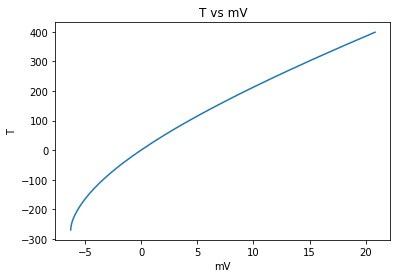

In [82]:
plt.plot(final_result, TempArray)
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.show()

### Trying with just taking linear approx on small scales

In [83]:
#splitting arrays in to 10 element arrays
mVArraysOf10 = np.split(final_result, len(final_result)/10)
TArraysOf10 = np.split(TempArray, len(final_result)/10)

for i in range(0, len(mVArraysOf10)):
    if (i != len(mVArraysOf10) - 1):
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i+1][0])
        TArraysOf10[i] = np.append(TArraysOf10[i], TArraysOf10[i+1][0])

    else:
        mVArraysOf10[i] = np.append(mVArraysOf10[i], mVArraysOf10[i-1][-1])
        TArraysOf10[i]= np.append(TArraysOf10[i], TArraysOf10[i-1][-1])


#get linear fit for each array of 10
fits = []

for i in range(0, int(len(final_result)/10)):
    popt, pcov = curve_fit(linear, mVArraysOf10[i], TArraysOf10[i])
    fits.append([popt, np.sqrt(np.diag(pcov))])
#     print(popt, np.sqrt(np.diag(pcov)))
    
# print(fits[-1])
# perr = np.sqrt(np.diag(fits[0][0]))
# print(perr)

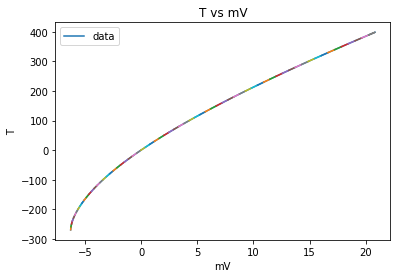

In [84]:
#plotting fits to make sure they match the data

plt.plot(final_result, TempArray, label="data")
plt.title("T vs mV")
plt.xlabel('mV')
plt.ylabel('T')
plt.legend()

for i in range(0, len(fits)):
    plt.plot(mVArraysOf10[i], linear(mVArraysOf10[i], fits[i][0][0], fits[i][0][1]))

plt.show()

## Errors
#### From Temp calibration  
LIMITS OF ERROR (whichever is greater)			
Standard	1.0Â°C or 0.75% Above 0Â°C	 1.0Â°C or 1.5% Below 0Â°C	
Special	0.5Â°C or 0.4%		
lets go with 1 degree for now

#### Model 199 DMM
0.0012(value) + 3^3 in last digit

In [85]:

"""
Takes input voltage (mV) and outputs corresponding temperature (C)
Must be run with mVArraysOf10[] and fits[]
Need errors


"""
def getTempFromVolt(V):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1])
            fitted = True

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            break
    
    return TempVal

def linearErr(V, erV, m, erM, b, erb):
    return np.sqrt( (m*V)**2*( (erM/m)**2+ (erV/V)**2) + (erb)**2 )

"""
Takes in a voltage and it's error.
Returns an array of the corresponding temp in kelvin and it's error
"""
def getTempFromVolt_Err(V, ErrV):
    fitted = False
    index = 0

    while fitted == False:
    #     print(min(mVArraysOf10[index]), (max(mVArraysOf10[index])) )
        if (min(mVArraysOf10[index]) <= V <= (max(mVArraysOf10[index])) ):
            TempVal = linear(V, fits[index][0][0], fits[index][0][1]) + 273.15
            fitted = True
            
            Err = linearErr(V, ErrV, fits[index][0][0], fits[index][1][0], fits[index][0][1], fits[index][1][1])
            #need to get errors
#             fits[index][1][0], fits[index][1][1] + error on V

        index+=1
        if index == len(fits):
            print("Error, Voltage not found.")
            TempVal = 0
            Err = 0
            break
    
    return [TempVal, Err]


"""
Given the data in voltages [V], returns an array of the same size with the error on each voltage
"""
def ErrOnVoltage(data):
    errStatic = 3**3*(1e-7)
    Err = []

    for row in data:
        row_err = []
        for ele in row:
            row_err.append(0.012*ele + errStatic) 

        Err.append(row_err)
        
    return np.array(Err)

# """
# DataM_T - full 8 column data array
# index = [a, b]
# returns (DataM_T[a] - DataM_T[b])/2
# and error.
# """
# def average(DataM_T, dataErrM_T, index):
    
#     hall = []
    
#     hallErr = []
    
#     for i in range(0, len(DataM_T[0])):
#         hall.append( (DataM_T[index[0]][i] - DataM_T[index[1]][i])/2 )
#         hallErr.append( np.sqrt((dataErrM_T[index[0]][i])**2 + (dataErrM_T[index[1]][i] )**2) /2 )

#     return hall, hallErr


"""
DataM_T - full 8 column data array
index = [a, b]
returns (DataM_T[a] - DataM_T[b])/2
and error.
"""
def HallV_removeR(DataMax, DataMin, dataErrM_T):
    
    hall = []
    hallErr = []
    
    for i in range(0, len(DataM_T[0])):
        hall.append( (DataM_T[index[0]][i] - DataM_T[index[1]][i])/2 )
        hallErr.append( np.sqrt((dataErrM_T[index[0]][i])**2 + (dataErrM_T[index[1]][i] )**2) /2 )

    return hall, hallErr

In [86]:
# Use function to get temp for a given V
V = -3.61
VoltErr = 0.012*V + 3**3*(1e-7) #this is sorta for the wrong range

Temp = getTempFromVolt_Err(V, VoltErr)
            
print("%f (%f) K" %(Temp[0], Temp[1]))

164.855995 (1.584915) K


### Data from max angle - heating up

In [87]:
# tempdataM_T_maxA  = [getTempFromVolt(V) for V in dataM_T_maxA[7]*1e3]

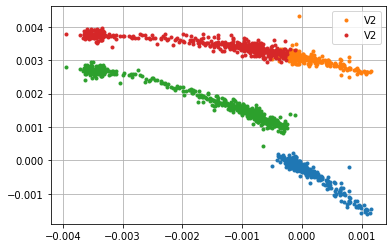

In [88]:
# peak = np.where(tempdataMandT == np.amax(tempdataMandT))[0][0]
# tempdataMandT = tempdataMandT[0:peak]
# dataMandT = dataMandT[:, 0:peak]

# print(len(dataMandT))

# plt.plot(tempdataMandT, ls=" ", marker=".")

# plt.grid()
# plt.xlabel("timeish")
# plt.ylabel("Temperature [C]")

# plt.show()

dataM_T_maxA_mid = np.transpose((np.loadtxt('Data/2020-02-21 11_53 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))[:, 100:760]
dataM_T_maxA_low = np.transpose((np.loadtxt('Data/2020-02-19 14_49 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))[:, 100:760]

plt.plot(dataM_T_maxA_mid[7], dataM_T_maxA_mid[0], ls=" ", marker=".")
plt.plot(dataM_T_maxA_mid[7], dataM_T_maxA_mid[1], ls=" ", marker=".", label="V2")

plt.plot(dataM_T_maxA_low[7], dataM_T_maxA_low[0], ls=" ", marker=".")
plt.plot(dataM_T_maxA_low[7], dataM_T_maxA_low[1], ls=" ", marker=".", label="V2")
plt.grid()
plt.legend()
plt.show()

# plt.plot(dataM_T_maxA_low[7], ls=" ", marker=".")
# plt.plot(dataM_T_maxA_mid[7], ls=" ", marker=".")
# plt.grid()
# plt.legend()
# plt.show()


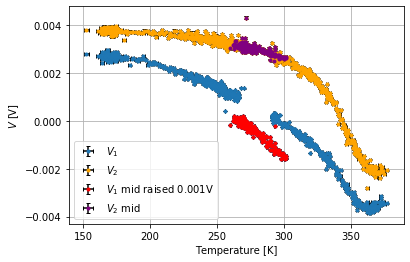

In [89]:
#stitching inputs together 
dataM_T_maxA_high = np.transpose((np.loadtxt('Data/2020-02-14 15_26 Voltage Readings Data_full.csv', delimiter=',', skiprows = 1)))
dataM_T_maxA_low = np.transpose((np.loadtxt('Data/2020-02-19 14_49 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))[:, 100:760]

#for some reason the V1 is a lot lower??
dataM_T_maxA_mid = np.transpose((np.loadtxt('Data/2020-02-21 11_53 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))[:, 100:760]

# dataM_T_maxA = np.concatenate((dataM_T_maxA_low, dataM_T_maxA_high), axis=1)
dataM_T_maxA = np.concatenate((dataM_T_maxA_low, dataM_T_maxA_mid, dataM_T_maxA_high), axis=1)

Err_M_T_maxA = ErrOnVoltage(dataM_T_maxA)

TempErr_M_T_maxA = [getTempFromVolt_Err(dataM_T_maxA[7][i]*1e3, Err_M_T_maxA[7][i]*1e3) for i in range(0, len(dataM_T_maxA[0])) ]
TempErr_M_T_maxA = np.transpose(TempErr_M_T_maxA)

plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[0], yerr=Err_M_T_maxA[0], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempErr_M_T_maxA[0], dataM_T_maxA[1], yerr=Err_M_T_maxA[1], xerr=TempErr_M_T_maxA[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

Err_M_T_mid = ErrOnVoltage(dataM_T_maxA_mid)
TempErr_M_T_mid = [getTempFromVolt_Err(dataM_T_maxA_mid[7][i]*1e3, Err_M_T_mid[7][i]*1e3) for i in range(0, len(dataM_T_maxA_mid[0])) ]
TempErr_M_T_mid = np.transpose(TempErr_M_T_mid)

#v1 seems to be really off, but v2 isn't for some reason
plt.errorbar(TempErr_M_T_mid[0], dataM_T_maxA_mid[0], yerr=Err_M_T_mid[0], xerr=TempErr_M_T_mid[1], ls=" ", marker=".", label="$V_1$ mid raised 0.001V", ecolor='black', capsize=2, color="r")

plt.errorbar(TempErr_M_T_mid[0], dataM_T_maxA_mid[1], yerr=Err_M_T_mid[1], xerr=TempErr_M_T_mid[1], ls=" ", marker=".", label="$V_2$ mid", ecolor='black', capsize=2, color="purple")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()

### Data from min angle - full range

In [90]:
#we're gonna have to cut the top of this as we were making ajustmenets
dataM_T_minA = np.transpose((np.loadtxt('Data/2020-02-17 14_28 Voltage Readings Data.csv', delimiter=',', skiprows = 1)))
#fixing temperature drop, just for this run
dataM_T_minA = np.concatenate((dataM_T_minA[:, 75:262], dataM_T_minA[:, 263:]), axis=1)

In [91]:
for i in range(0, len(dataM_T_minA[0])):
    if (i != len(dataM_T_minA[0])-1):
        if (dataM_T_minA[0][i] > (dataM_T_minA[0][i+1]+.001) ) | (dataM_T_minA[0][i] < (dataM_T_minA[0][i+1]-.001) ):
            print("too big")
            print(dataM_T_minA[0][i-1], dataM_T_minA[0][i], dataM_T_minA[0][i+1])
            #its the i+1 term that is the outlier
            print(i+1)

In [92]:
#REORDER in order of T
DataComS = dataM_T_minA
DataComS = np.transpose(dataM_T_minA)

DataComS = list(DataComS)
DataComS.sort(key=lambda pair: pair[7])

#transpose again to get reorded data in right shape
dataM_T_minA = np.transpose(np.array(DataComS))

#Get errors
Err_M_T_minA = ErrOnVoltage(dataM_T_minA)

tempDataHigher = []

for i in range(0, len(dataM_T_minA[7])):
    Temp = getTempFromVolt_Err(dataM_T_minA[7][i]*1e3, Err_M_T_minA[7][i]*1e3)
    if (i<261):
        Temp[0] = Temp[0] + 21  
    tempDataHigher.append(Temp)

TempErr_M_T_minA = np.transpose(tempDataHigher)

# plt.plot(TempErr_M_T_minA[0], dataM_T_minA[0], ls="-", marker="")

# plt.grid()
# plt.xlabel("temp")
# plt.ylabel("v")

# plt.show()

In [93]:
# a = [1,2,3,4,5]
# b = [5,2,4,7,3]
# new = list(zip(a,b))
# new.sort(key=lambda pair: pair[1])
# new

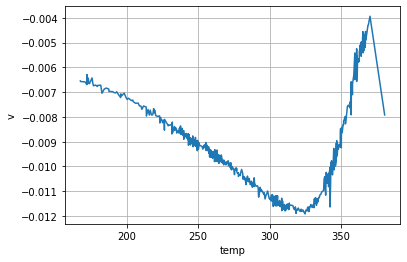

In [94]:
#using a boolean array that if a value must be deleted (so an either data row) the entry
#will be changed to 
maskT = np.ones(len(TempErr_M_T_minA[0]), dtype=bool)

#getting rid of any values that are in the wrong order or equal
for i in range(0, len(TempErr_M_T_minA[0])):
    if (i != len(TempErr_M_T_minA[0])-1):
        if (TempErr_M_T_minA[0][i] >= TempErr_M_T_minA[0][i+1]):
#             print([i+1])
#             print(TempErr_M_T_minA[0][i], TempErr_M_T_minA[0][i+1])
#             print(dataM_T_minA[0][i], dataM_T_minA[0][i+1])
            
            maskT[[i]] = False
            maskT[[i+1]] = False
            
    if (i < len(TempErr_M_T_minA[0])-2):
        if (TempErr_M_T_minA[0][i] > TempErr_M_T_minA[0][i+2]):
#             print([i+1])
#             print(TempErr_M_T_minA[0][i], TempErr_M_T_minA[0][i+2])
#             print(dataM_T_minA[0][i], dataM_T_minA[0][i+2])
            
            maskT[[i+2]] = False
            
TempErr_M_T_minA = TempErr_M_T_minA[:, maskT]
dataM_T_minA = dataM_T_minA[:, maskT]
Err_M_T_minA = Err_M_T_minA[:, maskT]

# print(len(TempErr_M_T_minA[0]), len(dataM_T_minA[0]), len(Err_M_T_minA[0]) )

plt.plot(TempErr_M_T_minA[0], dataM_T_minA[0], ls="-", marker="")

plt.grid()
plt.xlabel("temp")
plt.ylabel("v")

plt.show()

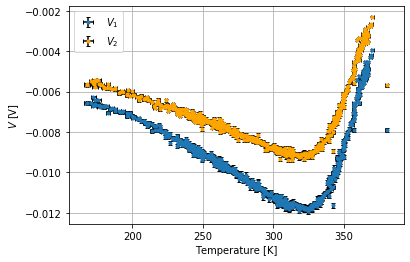

In [95]:
# DataCom_Err = ErrOnVoltage(DataCom)
    
plt.errorbar(TempErr_M_T_minA[0], dataM_T_minA[0], yerr=Err_M_T_minA[0], xerr=TempErr_M_T_minA[1], ls=" ", marker=".", label="$V_1$", ecolor='black', capsize=2)
plt.errorbar(TempErr_M_T_minA[0], dataM_T_minA[1], yerr=Err_M_T_minA[1], xerr=TempErr_M_T_minA[1], ls=" ", marker=".", label="$V_2$", ecolor='black', capsize=2, color="orange")

plt.grid()
plt.ylabel("$V$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()

In [96]:
for i in range(0, len(TempErr_M_T_minA[0])):
    if (i != len(TempErr_M_T_minA[0])-1):
        if (TempErr_M_T_minA[0][i] > TempErr_M_T_minA[0][i+1]):
            print([i+1])
            print(TempErr_M_T_minA[0][i], TempErr_M_T_minA[0][i+1])

In [97]:
# interperlating V2 data 

# print(type(dataM_T_minA[0].tolist()))

# InterpMin = interp1d(TempErr_M_T_minA[0], dataM_T_minA[1], kind='cubic')

# print(min(TempErr_M_T_minA[0]), max(TempErr_M_T_minA[0]))
# print(min(TempErr_M_T_maxA[0][61:]), max(TempErr_M_T_maxA[0][:]))

# #not sure which way this should go - also sorta ugly
# Removed = dataM_T_maxA[1][61:] - InterpMin(TempErr_M_T_maxA[0][61:])

# plt.plot(TempErr_M_T_maxA[0][61:], InterpMin(TempErr_M_T_maxA[0][61:]), ls=" ", marker=".", label="Interp minA values")
# plt.plot(TempErr_M_T_maxA[0], dataM_T_maxA[1], ls=" ", marker=".", label="maxA")
# plt.plot(TempErr_M_T_maxA[0][61:], Removed, ls=":", marker=" ", label="Removed", color="black")

# plt.grid()
# plt.ylabel("$V_2$", size=14)
# plt.xlabel("Temperature [k]")
# plt.legend()

# plt.show()


In [98]:
ele = 1.60217662e-19 #C
k = 8.617333262145e-5 #eV/K

V6_len = 4.800e-3 #in m, (0.002) mm
V5_len = 5.360e-3 #in m, (0.002) mm

gamma = 1e-3*V5_len / ( 0.91e-3*2.7e-3 ) #IL/A
B = 0.5 #in tesla
I = 1e-3 #A
t = 0.91e-3 #m

#old parameters from first fits
# Eg: 1.430054e+00
# Chp: 7.650499e+25
# C: 7.287881e+29
# power: 2.271244e+00

# Average values from V_4 and V_5
Eg = 1.429516e+00
pCh = 7.179949e+25
CnCe = 7.152223e+29
power = 2.262523e+00
    
# power = 2.27
# Eg = 1.43
# pCh = 7.650499e+25
# CnCe = 7.287881e+29


def hallVolt(T, Ch, Ce, m, b):
    coeff = I*B/(t*ele)
    num = Ch*pCh - (CnCe)*Ce*T**(power)*np.exp(-Eg/(2*k*T))
    denom = (pCh + (CnCe)*T**(power)*np.exp(-Eg/(2*k*T)))**2
    return coeff*(num/denom) + m*T + b

# def hallVolt(T, Ch, Ce, C):
#     coeff = I*B/(t*ele)
#     num = Ch*pCh - (CnCe)*Ce*T**(power*2-C)*np.exp(-Eg/(2*k*T))
#     denom = (pCh + (CnCe)*T**(power)*np.exp(-Eg/(2*k*T)))**2
#     return coeff*(num/denom)

In [99]:
# my_fitter = s.data.fitter()
# my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
#               , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# # help(s.data.fitter)

# guess='Ch=10e5, Ce=10e5, m=1, b=1'

# # voltage_EgapCompl(T, Eg, Chp, power, C)
# my_fitter.set_functions(f=hallVolt, p=guess)

# # plt.plot(TempErr_M_T_maxA[0][61:], Removed, ls=":", marker=" ", label="Removed", color="black")

# my_fitter.set_data(xdata=TempErr_M_T_maxA[0][61:], ydata=Removed, eydata=0.0001)
# # my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

# my_fitter.fit()
# # print()

In [108]:
def CenterTemp(TempErrM_T, dataM_T, Err_M_T):
    tempCentered = np.linspace(175, 371, 80)

    TempErr_center = []
    data_center = []
    Err_center = []

    for T in tempCentered:
        TempErr = []
        data = []
        Err = []

        for i in range(0, len(TempErrM_T[0])):
            if ((T - 2.5) <= TempErrM_T[0][i] and TempErrM_T[0][i] <= (T + 2.5)):
                TempErr.append(TempErrM_T[:, i])
                data.append(dataM_T[:, i])
                Err.append(Err_M_T[:, i])

        #get average of the data points
        ave = np.average(data, axis=0)
        data_center.append(ave)

        std = np.std(data, axis=0)
#         Err_center.append(std) #is this actually the error?
        Err_center.append(std/np.sqrt(len(TempErr))) #is this actually the error?


    data_center = np.transpose(np.array(data_center))
    Err_center = np.transpose(Err_center)

    return tempCentered, data_center, Err_center

def SubData(minData, minData_err, maxData, maxData_err):
    sub = (maxData - minData)/2
    err = np.sqrt(minData_err**2 + maxData_err**2)/2

    return sub, err

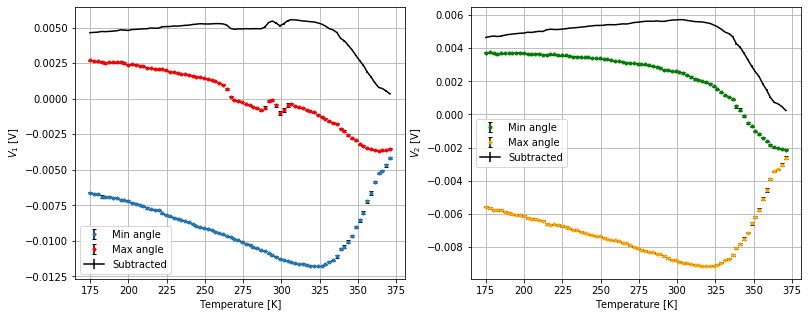

In [109]:
# print(TempErr_M_T_minA[0])

tempCentered, data_minA_center, Err_minA_center = CenterTemp(TempErr_M_T_minA, dataM_T_minA, Err_M_T_minA)
tempCentered, data_maxA_center, Err_maxA_center = CenterTemp(TempErr_M_T_maxA, dataM_T_maxA, Err_M_T_maxA)

subtracted_1 = SubData(data_minA_center[0], Err_minA_center[0], data_maxA_center[0], Err_maxA_center[0])
subtracted_2 = SubData(data_minA_center[1], Err_minA_center[1], data_maxA_center[1], Err_maxA_center[1])

# print(subtracted_1[1])

plt.figure(figsize=(13,5))
plt.subplot(1, 2, 1)

plt.errorbar(tempCentered, data_minA_center[0], yerr=Err_minA_center[0], ls=" ", marker=".", label="Min angle", ecolor='black', capsize=2)
plt.errorbar(tempCentered, data_maxA_center[0], yerr=Err_maxA_center[0], ls=" ", marker=".", label="Max angle", ecolor='black', capsize=2, color="r")
plt.errorbar(tempCentered, subtracted_1[0], yerr=subtracted_1[1], color="black", label="Subtracted")

plt.grid()
plt.ylabel("$V_1$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(tempCentered, data_maxA_center[1], yerr=Err_maxA_center[1], ls=" ", marker=".", label="Min angle", ecolor='black', capsize=2, color="g")
plt.errorbar(tempCentered, data_minA_center[1], yerr=Err_minA_center[1], ls=" ", marker=".", label="Max angle", ecolor='black', capsize=2, color="orange")
plt.errorbar(tempCentered, subtracted_2[0], yerr=subtracted_2[1], color="black", label="Subtracted")

plt.grid()
plt.ylabel("$V_2$ [V]")
plt.xlabel("Temperature [K]")
plt.legend()

plt.show()
# print(len(data_minA_center[0]))

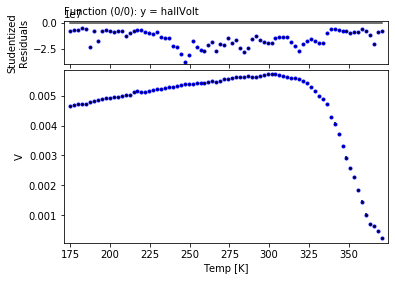

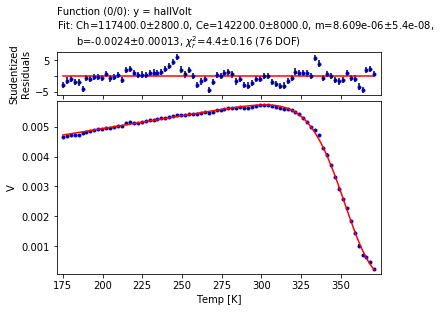


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Temp [K]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['V']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 295875080774573.8 +/- 0.16, 76.0 DOF)
  Ch         = 1000000.0
  Ce         = 1000000.0
  m          = 1.0
  b          = 1.0

FIT RESULTS (reduced chi^2 = 4.4 +/- 0.16, 76 DOF)

In [117]:
my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# help(s.data.fitter)

guess='Ch=10e5, Ce=10e5, m=1, b=1'

my_fitter.set_functions(f=hallVolt, p=guess)

# tempCentered, subtracted[1]
my_fitter.set_data(xdata=tempCentered, ydata=subtracted_2[0], eydata=subtracted_2[1])
# my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

my_fitter.fit()
# print()

In [118]:
fits = my_fitter.get_fit_results()

Ch = fits.get('Ch')
Ce = fits.get('Ce')
m = fits.get('m')
b = fits.get('b')

Cn = 5.031216e+24
p = 6.115945e+20


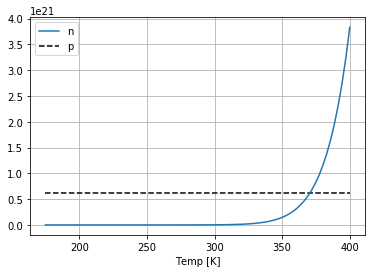

In [132]:
print("Cn = %e" %(CnCe/Ce))
p = pCh/Ch
print("p = %e" %p)
# print("u_p = %e" %(pCh/Ch))

T = 290
tempCentered = np.linspace(175, 400, 80)

def n(T):
    n = (CnCe/Ce)* T **power * np.exp(-Eg/(2*k*T))
    return n
    
# print("n = %e" %(n))

plt.plot(tempCentered, n(tempCentered), label="n")
plt.hlines(p, xmin=min(tempCentered), xmax=max(tempCentered), ls="--", label="p")
# plt.ylabel("")
plt.xlabel("Temp [K]")
plt.legend()
plt.grid()
plt.show()

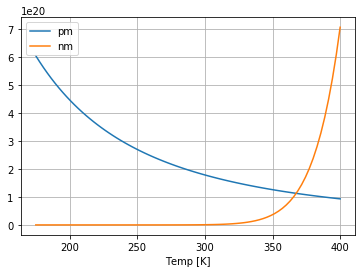

In [133]:

def mobil(T):
    pm = p*(Ch*T**(-1*power))

    nm = CnCe*np.exp(-Eg/(2*k*T))
    
    return pm, nm

mobils = mobil(tempCentered)

plt.plot(tempCentered, mobils[0], label="pm")
plt.plot(tempCentered, mobils[1],label="nm" )
# plt.ylabel("")
plt.xlabel("Temp [K]")
plt.legend()
plt.grid()
plt.show()

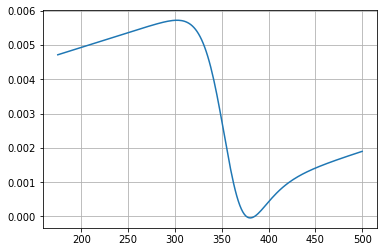

In [112]:
#extending the data to see what it does
TExtend = np.linspace(175, 500, 200)

# Ch         = 8.89e-12 #+/- 3.3e-13
# Ce         = 1.313e-11 #+/- 9.4e-13
# m          = 1.747e-05 #+/- 3e-07
# b          = -0.00425 #+/- 0.0003

plt.plot(TExtend, hallVolt(TExtend, Ch, Ce, m, b))
plt.grid()
plt.show()

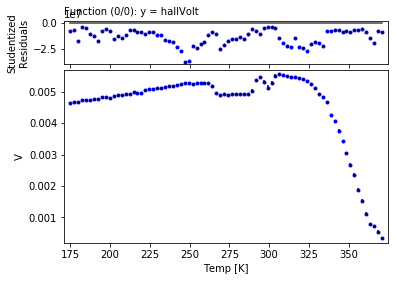

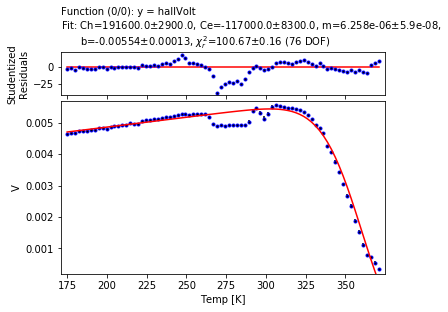


SETTINGS
  autoplot        True
  coarsen         [1]
  first_figure    0
  fpoints         [None]
  plot_all_data   [False]
  plot_bg         [True]
  plot_errors     [True]
  plot_fit        [True]
  plot_guess      [False]
  plot_guess_zoom [False]
  scale_eydata    [1.0]
  silent          False
  style_bg        [{'marker': '', 'color': 'k', 'ls': '-'}]
  style_data      [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]
  style_fit       [{'marker': '', 'color': 'r', 'ls': '-'}]
  style_guess     [{'marker': '', 'color': '0.25', 'ls': '-'}]
  subtract_bg     [False]
  xlabel          ['Temp [K]']
  xmax            [None]
  xmin            [None]
  xscale          ['linear']
  ylabel          ['V']
  ymax            [None]
  ymin            [None]
  yscale          ['linear']

GUESS (reduced chi^2 = 243521403965480.25 +/- 0.16, 76.0 DOF)
  Ch         = 1000000.0
  Ce         = 1000000.0
  m          = 1.0
  b          = 1.0

FIT RESULTS (reduced chi^2 = 100.67 +/- 0.16, 76 

In [113]:
#fit for v5

my_fitter = s.data.fitter()
my_fitter.set(style_data = [{'marker': '.', 'color': 'black', 'ls': '', 'mec': 'b'}]\
              , plot_guess=False, fpoints=None, xlabel = "Temp [K]" , ylabel = "V")
# help(s.data.fitter)

guess='Ch=10e5, Ce=10e5, m=1, b=1'

# voltage_EgapCompl(T, Eg, Chp, power, C)
my_fitter.set_functions(f=hallVolt, p=guess)

# tempCentered, subtracted[1]
my_fitter.set_data(xdata=tempCentered, ydata=subtracted_1[0], eydata=subtracted_1[1])
# my_fitter.set_data(data=TempDataComHigh[0][100:], ydata=DataComHigh[4][100:])

my_fitter.fit()
# print()